<a href="https://colab.research.google.com/github/gc2321/3235-Machine-Learning/blob/main/XTRA_NEURO_NET_EXERCISES/3_rnn_frozen_dessert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
random.seed(42)

In [4]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

import fileinput
filePath ="/content/gdrive/MyDrive/neural_data/Frozen_Dessert_Production.csv"

import pandas as pd
df = pd.read_csv(filePath,index_col='DATE',parse_dates=True)

df.head(3)


Mounted at /content/gdrive


,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [7]:
df.columns = ['Production']

<Axes: xlabel='DATE'>

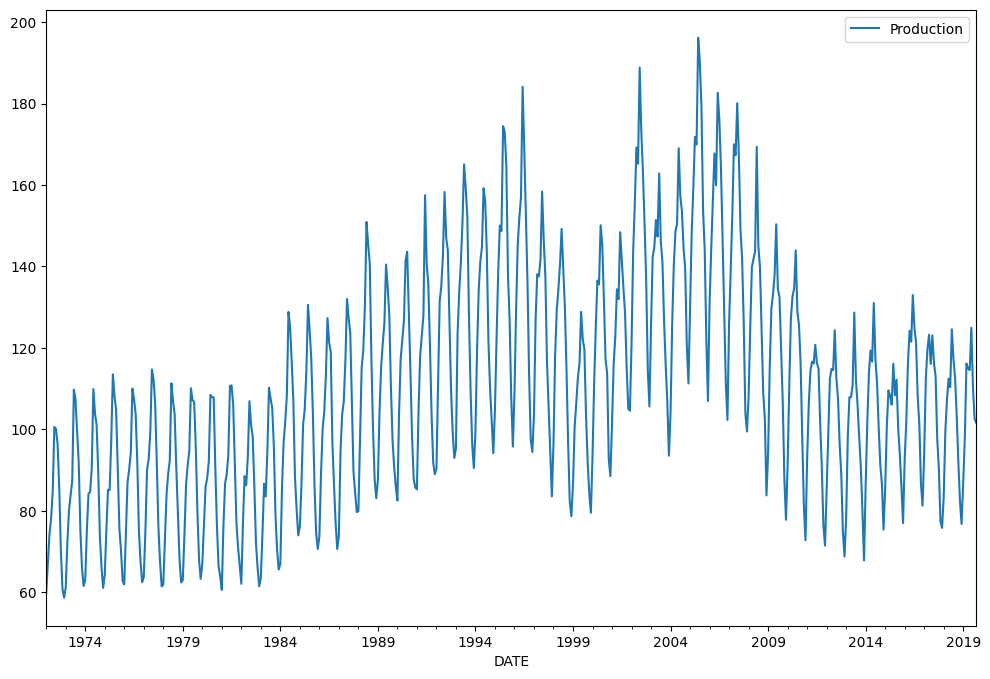

In [8]:
df.plot(figsize=(12,8))

## Train Test Split

In [9]:
# data is monthly, do forest for 1.5 years into the future
len(df)


573

In [10]:
test_size = 24

In [11]:
test_ind = len(df)- test_size

In [12]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [13]:
train.head(3)

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350


In [15]:
test.head(3)

,Production
DATE,
2017-10-01,90.4732
2017-11-01,77.4378
2017-12-01,75.8118


## Scale Data

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [17]:
scaler.fit(train)

MinMaxScaler()

In [18]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Time Series Generator

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
length = 18
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [22]:
# What does the first batch look like?
X,y = generator[0]

In [23]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.
 0.01774221 0.09850931 0.15590133 0.18358944 0.20878908 0.37150354]
Predict this y: 
 [[0.3542551]]


## Create the Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [26]:
# We're only using one feature in our time series
n_features = 1

In [27]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
# early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [30]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [31]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


<ipython-input-31-3878a3328f67>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


531/531 [==============================] - 9s 13ms/step - loss: 0.0282 - val_loss: 0.0043
Epoch 2/20
531/531 [==============================] - 8s 14ms/step - loss: 0.0120 - val_loss: 0.0014
Epoch 3/20
531/531 [==============================] - 6s 11ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 4/20
531/531 [==============================] - 6s 12ms/step - loss: 0.0039 - val_loss: 0.0046


In [32]:
losses = pd.DataFrame(model.history.history)

<Axes: >

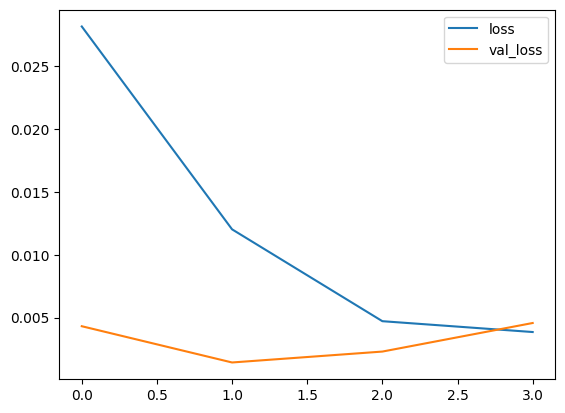

In [33]:
losses.plot()

## Evaluate on Test Data

In [34]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [35]:
true_predictions = scaler.inverse_transform(test_predictions)

In [36]:
test['Predictions'] = true_predictions

<ipython-input-36-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [37]:
test.head(5)

,Production,Predictions
DATE,,
2017-10-01,90.4732,96.618369
2017-11-01,77.4378,94.949994
2017-12-01,75.8118,100.399731
2018-01-01,83.4343,112.408301
2018-02-01,99.4899,122.561249


<Axes: xlabel='DATE'>

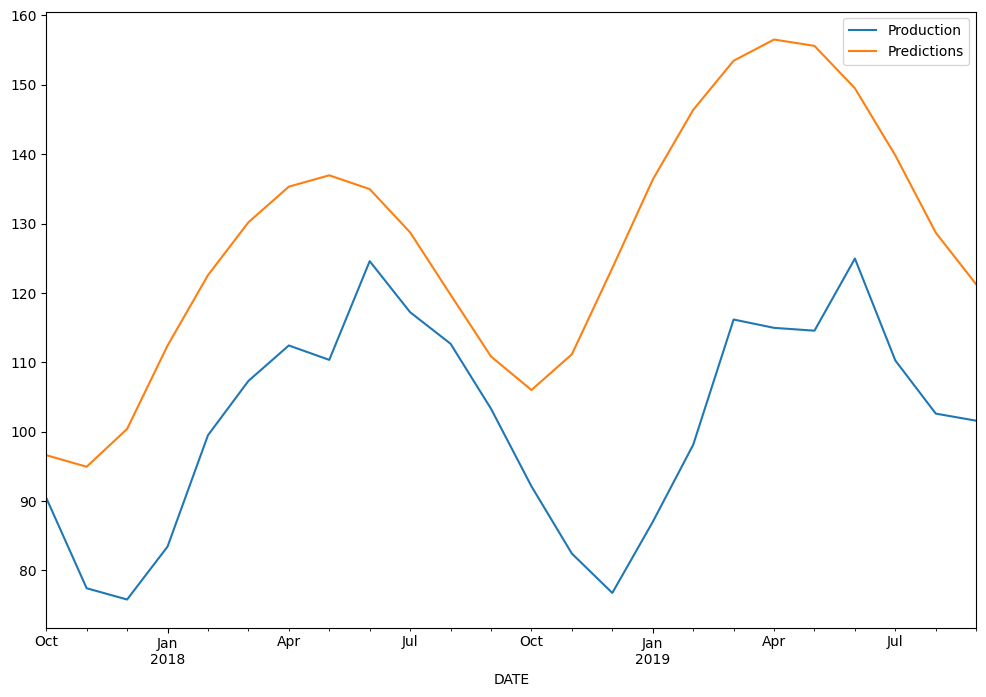

In [38]:
test.plot(figsize=(12,8))

In [ ]:
# calculate RMSE
